<a href="https://colab.research.google.com/github/Francescolv99/Deep-Video-Deblurring/blob/main/Image_Deblurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ottengo il dataset scaricandolo dal link in questione


In [ ]:
!wget http://www.cs.ubc.ca/labs/imager/tr/2017/DeepVideoDeblurring/DeepVideoDeblurring_Dataset.zip
!unzip /content/DeepVideoDeblurring_Dataset.zip

Importo i pacchetti necessari

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import pandas as pd
import os

Creo le variabili x e y e le funzioni necessarie per lavorare il dataset

In [5]:
#dim immagini 720x1280x3
x = []
y = []

def appendImmagine(filename, x):
    im_1 = Image.open(filename)
    ar = np.array(im_1)
    ar = ar[300:400,600:700]
    x.append(ar)
    #x=np.append(x,ar)
    return x
    
#accedo ad ogni immagine nel database e le inserisco in forma matriciale in x e y
def ottieniImmagini(filename, x , y):
    x2 = []
    y2 = []
    #apro la cartella del dataset
    entries = os.listdir(filename)
    #entries.pop(0)
    #apro ogni sottocartella
    print("LOADING DATASET:")
    counter = 0
    for cartella in entries:
      #cartella è per esempio 720p_240fps_1
        #print(cartella)
        if(cartella==".DS_Store" or cartella=="IMG_0051" or cartella=="IMG_0053" or cartella=="IMG_0049"):
              continue
        counter+=1
        print(str(counter)+"/68 "+"Carico " + cartella)
        x, y = ottieniImmaginiCartella(filename + '/' + cartella,x,y)
        lunghezza = len(x)
        x = np.array(x)
        y = np.array(y)
        i = 0
        while i<lunghezza:
          x2.append(x[i])
          y2.append(y[i])
          i+=1
        x=[]
        y=[]
    x2 = np.array(x2)
    y2 = np.array(y2)
    print("Caricamento completato")
    return x2, y2

def ottieniImmaginiCartella(filename,x, y):
    #apro la cartella del dataset
    entries = os.listdir(filename)
    #entries.pop(0)
    #apro ogni sottocartella
    for cartella in entries:
        if(cartella=="input"):
            lista_immagini = os.listdir(filename + '/' + cartella)
            #a = 0
            for immagine in lista_immagini:
                #if a==50:
                    #break
                if(immagine==".DS_Store"): 
                    continue
                x = appendImmagine(filename + '/' + cartella + '/' + immagine, x)
                #a+=1
        elif(cartella==".DS_Store"):
          continue
        else:
            lista_immagini = os.listdir(filename + '/' + cartella)
            #b = 0
            for immagine in lista_immagini:
                #if b==50:
                    #break
                if(immagine==".DS_Store"): 
                    continue
                y = appendImmagine(filename + '/' + cartella + '/' + immagine, y)
                #b+=1
    return x, y

In [ ]:
#68 cartelle
x, y = ottieniImmagini('/content/DeepVideoDeblurring_Dataset/quantitative_datasets', x , y)

In [7]:
print(np.shape(x),np.shape(y))

(6408, 100, 100, 3) (6408, 100, 100, 3)


Immagini di input


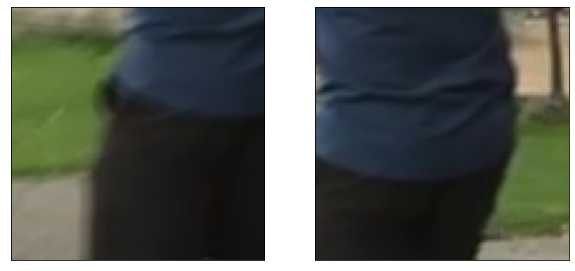

Immagini definite


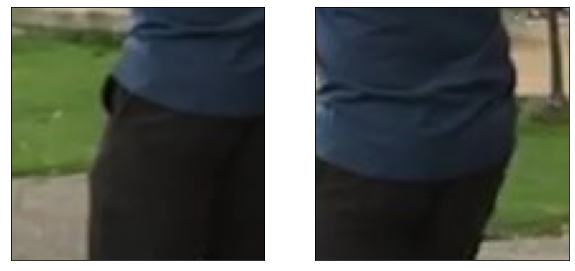

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
print('Immagini di input')
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
plt.show()
plt.figure(figsize = (10, 10))
print('Immagini definite')
for i in range(2):
    plt.subplot(1,2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y[i], cmap=plt.cm.binary)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
#normaliziamo l'input tra 0 e 1

x_train = x_train/255
y_train = y_train/255
x_test = x_test/255
y_test = y_test/255

del x
del y

In [10]:
from keras import models, layers
model = models.Sequential()
#encode
model.add(layers.Conv2D(64, (2, 2), strides = 1, padding = 'same', input_shape = (100, 100, 3)))
model.add(layers.Conv2D(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2D(16, (2, 2), strides = 1, padding = 'same'))
#latent
model.add(layers.Conv2D(8, (2, 2), strides = 1, padding = 'same'))
#decode
model.add(layers.Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same'))
model.add(layers.Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same'))
model.compile(loss="mse",
              optimizer='adam',
              metrics=["mse"]) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 8)       520       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 100, 16)     528       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 100, 100, 32)     2080      
 ranspose)                                              

In [ ]:
# train the model
history = model.fit(
    x=x_train.reshape(-1, 100, 100, 3),
    y=y_train.reshape(-1, 100, 100, 3),
    epochs=1000,
    verbose = 1,
    #shuffle=True,
    validation_data=(x_test.reshape(-1, 100, 100, 3), y_test.reshape(-1, 100, 100, 3)),
)


41/41 [==============================] - 1s 20ms/step - loss: 0.0028 - mse: 0.0028
mse: 0.28%


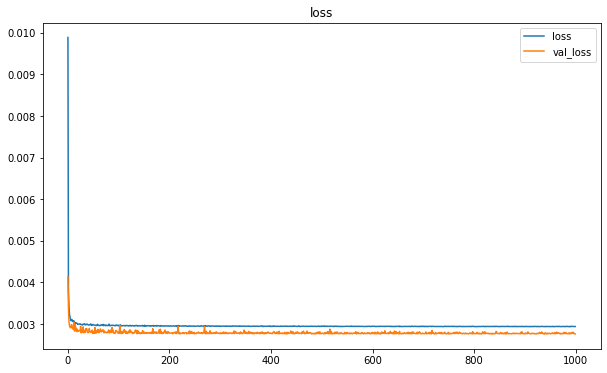

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

plot_loss(history)

#plot_accuracy(history)

scores = model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Immagini di input


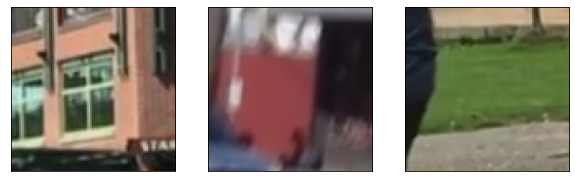

Deblurred images


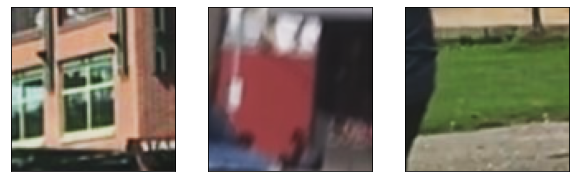

HD Images


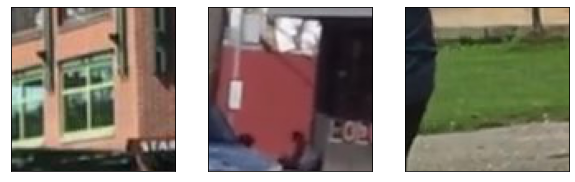

In [13]:
decoded_imgs = model.predict(x_test.reshape(-1, 100, 100, 3))
plt.figure(figsize = (10, 10))
print('Immagini di input')
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
plt.show()
plt.figure(figsize = (10, 10))
print('Deblurred images')
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(decoded_imgs[i], cmap=plt.cm.binary)
plt.show()
plt.figure(figsize = (10, 10))
print('HD Images')
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(y_test[i], cmap=plt.cm.binary)
plt.show()